# Cross-Validation and Learning Curves

This notebook evaluates model generalization using **cross-validation** and **learning curves**.
The goal is to obtain more reliable estimates of performance and to visualize underfitting/overfitting behavior as training data increases.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

### Load dataset

In [3]:
data = fetch_california_housing(as_frame=True)
df = data.frame

X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

X.shape, y.shape

((20640, 8), (20640,))

## Why Cross-Validation?

A single train/test split can produce optimistic or pessimistic estimates depending on randomness.
Cross-validation reduces this risk by evaluating the model on multiple folds, providing a more robust estimate of generalization performance.

In [4]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Helper function (CV RMSE)

In [5]:
def cv_rmse(model, X, y, cv):
    scores = cross_val_score(
        model, X, y,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )
    rmse_scores = -scores
    return rmse_scores.mean(), rmse_scores.std()

## Models Evaluated (Cross-Validation)

We evaluate:
- **Linear Regression** (baseline)
- **Ridge Regression** (regularized linear model)
- **Decision Tree (unrestricted)** (high variance / overfitting-prone)
- **Decision Tree (regularized)** (reduced variance)

### Define models

In [6]:
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Ridge Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),
    "Decision Tree (unrestricted)": DecisionTreeRegressor(random_state=42),
    "Decision Tree (regularized)": DecisionTreeRegressor(
        max_depth=5,
        min_samples_leaf=20,
        random_state=42
    )
}

### Run CV and create results table

In [7]:
rows = []

for name, model in models.items():
    mean_rmse, std_rmse = cv_rmse(model, X, y, cv)
    rows.append({
        "Model": name,
        "CV RMSE Mean": mean_rmse,
        "CV RMSE Std": std_rmse
    })

cv_results = pd.DataFrame(rows).sort_values("CV RMSE Mean")
cv_results

,Model,CV RMSE Mean,CV RMSE Std
2,Decision Tree (unrestricted),0.715158,0.008655
3,Decision Tree (regularized),0.718037,0.014064
1,Ridge Regression,0.728249,0.014928
0,Linear Regression,0.728251,0.014936


## Cross-Validation Results Interpretation

The unrestricted Decision Tree achieved the lowest average CV RMSE. However, cross-validation results must be interpreted alongside model stability and variance behavior.

While a lower mean RMSE suggests better predictive accuracy, the learning curves indicate that the unrestricted tree exhibits strong overfitting characteristics.

Ridge and Linear Regression models show slightly higher RMSE values but demonstrate more stable and consistent performance across folds.

Therefore, model selection should consider not only average error but also generalization behavior and robustness.

## Learning Curves

Learning curves show how model performance changes as the training set grows.
They help diagnose:

- **Underfitting:** training and validation errors are both high.
- **Overfitting:** training error is low but validation error is high.
- **Good fit:** both errors converge to a low value as data increases.

### Helper function to plot learning curves

In [8]:
def plot_learning_curve(estimator, title, X, y, cv):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X, y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 6),
        n_jobs=-1
    )

    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_rmse, marker="o", label="Training RMSE")
    plt.plot(train_sizes, val_rmse, marker="o", label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

### Plot learning curves for two key models

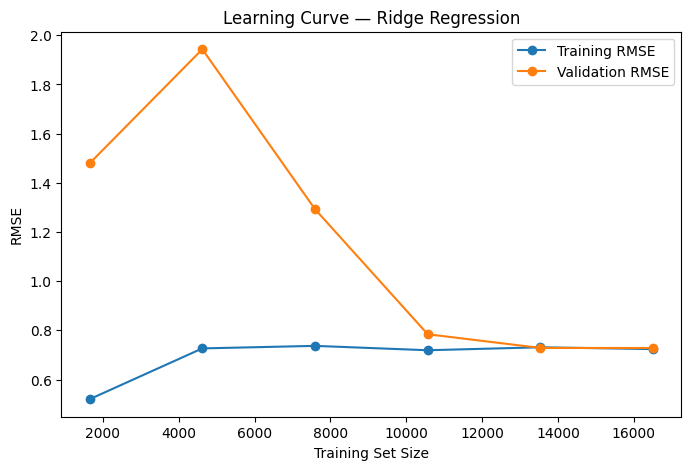

In [10]:
plot_learning_curve(
    models["Ridge Regression"],
    "Learning Curve — Ridge Regression",
    X, y, cv
)

### Ridge Regression Analysis

The training and validation curves converge as the dataset size increases, indicating stable learning behavior.

The relatively small gap between training and validation RMSE suggests good generalization and low variance. The model benefits from regularization and demonstrates consistent performance.

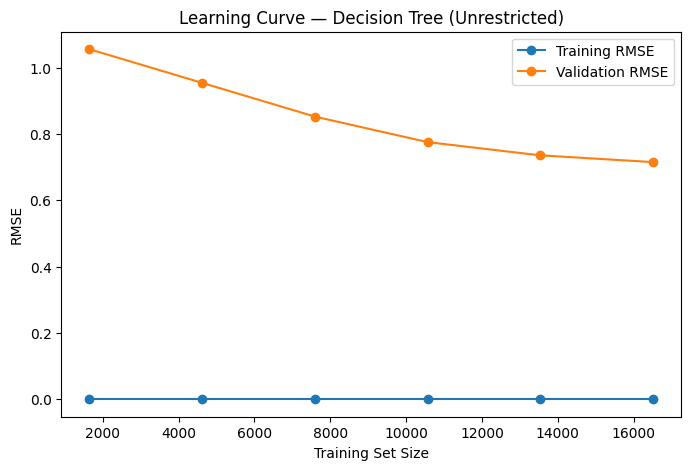

In [11]:
plot_learning_curve(
    models["Decision Tree (unrestricted)"],
    "Learning Curve — Decision Tree (Unrestricted)",
    X, y, cv
)

### Decision Tree (Unrestricted) Analysis

The training RMSE is near zero across all dataset sizes, while the validation RMSE remains significantly higher.

This large gap is a classic sign of overfitting: the model memorizes the training data but fails to generalize effectively.

Although cross-validation reports competitive average RMSE, the structural behavior of the model reveals high variance and sensitivity.

## Final Conclusion

Cross-validation provided a more reliable estimate of model performance compared to a single train/test split.

Although the unrestricted Decision Tree achieved the lowest CV RMSE, its learning curve revealed strong overfitting behavior, characterized by near-zero training error and a persistent gap between training and validation performance.

Ridge Regression, while slightly less accurate in terms of average RMSE, demonstrated greater stability and consistent generalization.

This analysis highlights an important principle in machine learning: the best model is not necessarily the one with the lowest error, but the one that balances accuracy, stability, and generalization.